In [1]:
import zipfile
with zipfile.ZipFile('histopathologic-cancer-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [3]:
import numpy as np
import pandas as pd
from glob import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai.vision import *
from fastai.metrics import error_rate

In [6]:
path=Path('~/practicum/kaggle/data/').expanduser()
train_path=path/'train/'
test_path=path/'test/'
train_label=path/'train_labels.csv'
ORG_SIZE=96

bs=64
num_workers=None # Apprently 2 cpus per kaggle node, so 4 threads I think
sz=96

In [7]:
train_lbl = pd.read_csv(train_label)

In [8]:
train_lbl['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

# Visualization_2 (fast.ai)

In [9]:
fnames = get_image_files(train_path)
fnames[:5]

[PosixPath('/home/linqisheng/practicum/kaggle/data/train/e2193a775d7bf0897401851eed9624f007168b96.tif'),
 PosixPath('/home/linqisheng/practicum/kaggle/data/train/40f88d27b526c55367cfd359a66e448297478cc8.tif'),
 PosixPath('/home/linqisheng/practicum/kaggle/data/train/f027553a2c185ef758360656544a0f5d7063c240.tif'),
 PosixPath('/home/linqisheng/practicum/kaggle/data/train/4ae52ce6df0957a73a4a48306c52e8086ad771d0.tif'),
 PosixPath('/home/linqisheng/practicum/kaggle/data/train/9d1aca1672cf6d12da4bdb12a19d7d10a70f9b5d.tif')]

In [10]:
from sklearn.model_selection import train_test_split

# we read the csv file earlier to pandas dataframe, now we set index to id so we can perform
train_df = train_lbl.set_index('id')

train_names = train_df.index.values
train_labels = np.asarray(train_df['label'].values)

# split, this function returns more than we need as we only need the validation indexes for fastai
tr_n, val_n, tr_idx,val_idx = train_test_split(train_names, range(len(train_names)), test_size=0.1, stratify=train_labels, random_state=123)

In [11]:
arch = models.resnet34                  # specify model architecture, densenet169 seems to perform well for this data but you could experiment                     # input size is the crop size
MODEL_PATH = str(arch).split()[1]   # this will extrat the model name as the model file name e.g. 'resnet50'



In [12]:
train_dict = {'name': train_names, 'label': train_labels}
df = pd.DataFrame(data=train_dict)
# create test dataframe
test_names = []
for f in os.listdir(test_path):
    test_names.append(f)
df_test = pd.DataFrame(np.asarray(test_names), columns=['name'])

In [13]:
df['name']

0         f38a6374c348f90b587e046aac6079959adf3835
1         c18f2d887b7ae4f6742ee445113fa1aef383ed77
2         755db6279dae599ebb4d39a9123cce439965282d
3         bc3f0c64fb968ff4a8bd33af6971ecae77c75e08
4         068aba587a4950175d04c680d38943fd488d6a9d
                            ...                   
220020    53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6
220021    d4b854fe38b07fe2831ad73892b3cec877689576
220022    3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75
220023    f129691c13433f66e1e0671ff1fe80944816f5a2
220024    a81f84895ddcd522302ddf34be02eb1b3e5af1cb
Name: name, Length: 220025, dtype: object

In [14]:
data = ImageList.from_df(path=train_path ,
                              df=df, suffix = '.tif')\
.split_by_idx(val_idx)\
.label_from_df(cols='label')\
.add_test(ImageList.from_df(path=test_path, df=df_test))\
.transform(tfms=[[],[]], size=sz)\
.databunch(bs=bs)

    
    

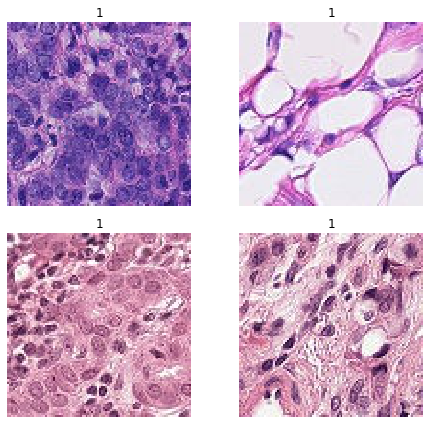

In [15]:
data.show_batch(rows=2, figsize=(7,6))

# Training: resnet34

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [17]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [18]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

In [ ]:
learn.save('stage-1')

# Results

In [63]:
learn.unfreeze()

In [64]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.106948,0.105342,0.036813,02:56


In [19]:
learn.load('stage-1');

In [66]:
### learning rate finder
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


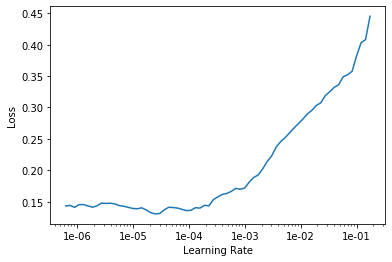

In [67]:
learn.recorder.plot()

In [68]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.142052,0.133587,0.048266,02:52
1,0.112759,0.125527,0.044358,02:51


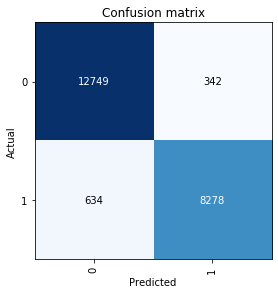

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title='Confusion matrix')

In [21]:
learn.save('stage-1');

In [22]:
preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.9556424021720886 %.


# submit

In [42]:
sample_df = pd.read_csv(path/'sample_submission.csv')
sample_list = list(sample_df.id)

# List of tumor preds. 
# These are in the order of our test dataset and not necessarily in the same order as in sample_submission
preds,y = learn.get_preds(ds_type=DatasetType.Test, with_loss=False)
tumor_preds = preds[:, 1]
pred_list = [p for p in tumor_preds]

# To know the id's, we create a dict of id:pred
pred_dic = dict((key, value.item()) for (key, value) in zip(learn.data.test_ds.items, pred_list))

# Now, we can create a new list with the same order as in sample_submission
pred_list_cor = [pred_dic['/home/linqisheng/practicum/kaggle/data/test/'+ id +'.tif'] for id in sample_list]

# Next, a Pandas dataframe with id and label columns.
df_sub = pd.DataFrame({'id':sample_list,'label':pred_list_cor})

# Export to csv
df_sub.to_csv('{0}_submission.csv'.format(MODEL_PATH), header=True, index=False)

In [43]:
df_sub.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,1.804571e-01
1,95596b92e5066c5c52466c90b69ff089b39f2737,2.031454e-01
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,4.322239e-07
3,2c35657e312966e9294eac6841726ff3a748febf,2.737493e-02
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,2.490776e-03


In [46]:
from IPython.display import FileLink
FileLink(r'resnet34_submission.csv')

/home/linqisheng/practicum/kaggle/resnet34_submission.csv